# Correlation analysis


## Setup

imports, loads and minimal clean

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from typing import *
from collections import defaultdict


In [ ]:
# import data

XTUDAO = Path("data/01--grouped/X_tudao.parquet")

X = pd.read_parquet(XTUDAO)

print(X.shape)

groups = defaultdict(list)
cols = X.columns.tolist()

for col in cols:
    group = col.split("_-_")[0]
    groups[group].append(col)

for group, cols in groups.items():    
    print(f"{group}:")
    for col in cols:
        print(f"  - {'_-_'.join(col.split('_-_')[1:])}")

print()
print(X.head(10).to_markdown())



(5844, 182)
contratos:
  - boi_gordo_b3_pregão_regular_-_contract_month
  - boi_gordo_b3_pregão_regular_-_indicator_name
  - boi_gordo_b3_pregão_regular_-_price
  - boi_gordo_b3_pregão_regular_-_variation
gov:
  - gov_-_consumo_familias
  - gov_-_consumo_familias_dessaz
  - gov_-_consumo_governo
  - gov_-_consumo_governo_dessaz
  - gov_-_desembolso_bndes
  - gov_-_emprego_formal_comercio
  - gov_-_emprego_formal_comercio_dessaz
  - gov_-_emprego_formal_construcao_civil
  - gov_-_emprego_formal_construcao_civil_dessaz
  - gov_-_emprego_formal_servicos
  - gov_-_emprego_formal_servicos_dessaz
  - gov_-_emprego_formal_total
  - gov_-_emprego_formal_total_dessaz
  - gov_-_emprego_formal_transformacao
  - gov_-_emprego_formal_transformacao_dessaz
  - gov_-_exportacao
  - gov_-_exportacao_dessaz
  - gov_-_faturamento_real_bk_mecanicos
  - gov_-_fbcf
  - gov_-_fbcf_dessaz
  - gov_-_forca_trabalho_desocupadas
  - gov_-_forca_trabalho_ocupadas
  - gov_-_forca_trabalho_total
  - gov_-_icc_condic

In [3]:
# minimal clean

from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd


def clean_timeseries(X: pd.DataFrame, use_zscore: bool = True) -> tuple[pd.DataFrame, Dict[str, List[str]]]:
    """Drop non-numeric cols, normalize per column, set non-finite to NaN; returns (X_clean, steps)."""
    steps: Dict[str, List[str]] = {}

    Z = X.select_dtypes(include=[np.number]).copy()
    for c in Z.columns:
        steps[c] = ["keep_numeric"]

    Z = Z.replace([np.inf, -np.inf], np.nan)

    if use_zscore:
        mu = Z.mean()
        sd = Z.std(ddof=0).replace(0.0, np.nan)
        Z = (Z - mu) / sd
        norm_tag = "normalize:zscore"
    else:
        mn = Z.min()
        mx = Z.max()
        rng = (mx - mn).replace(0.0, np.nan)
        Z = (Z - mn) / rng
        norm_tag = "normalize:minmax"

    for c in Z.columns:
        steps[c].append("nanify_non_finite")
        steps[c].append(norm_tag)

    Z = Z.astype("float64")

    return Z, steps


X_clean, steps = clean_timeseries(X, use_zscore=True)
print(X_clean.shape)


(5844, 161)


## Missing values

inspect missing values per granularity

/tmp/ipykernel_603976/2132723248.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


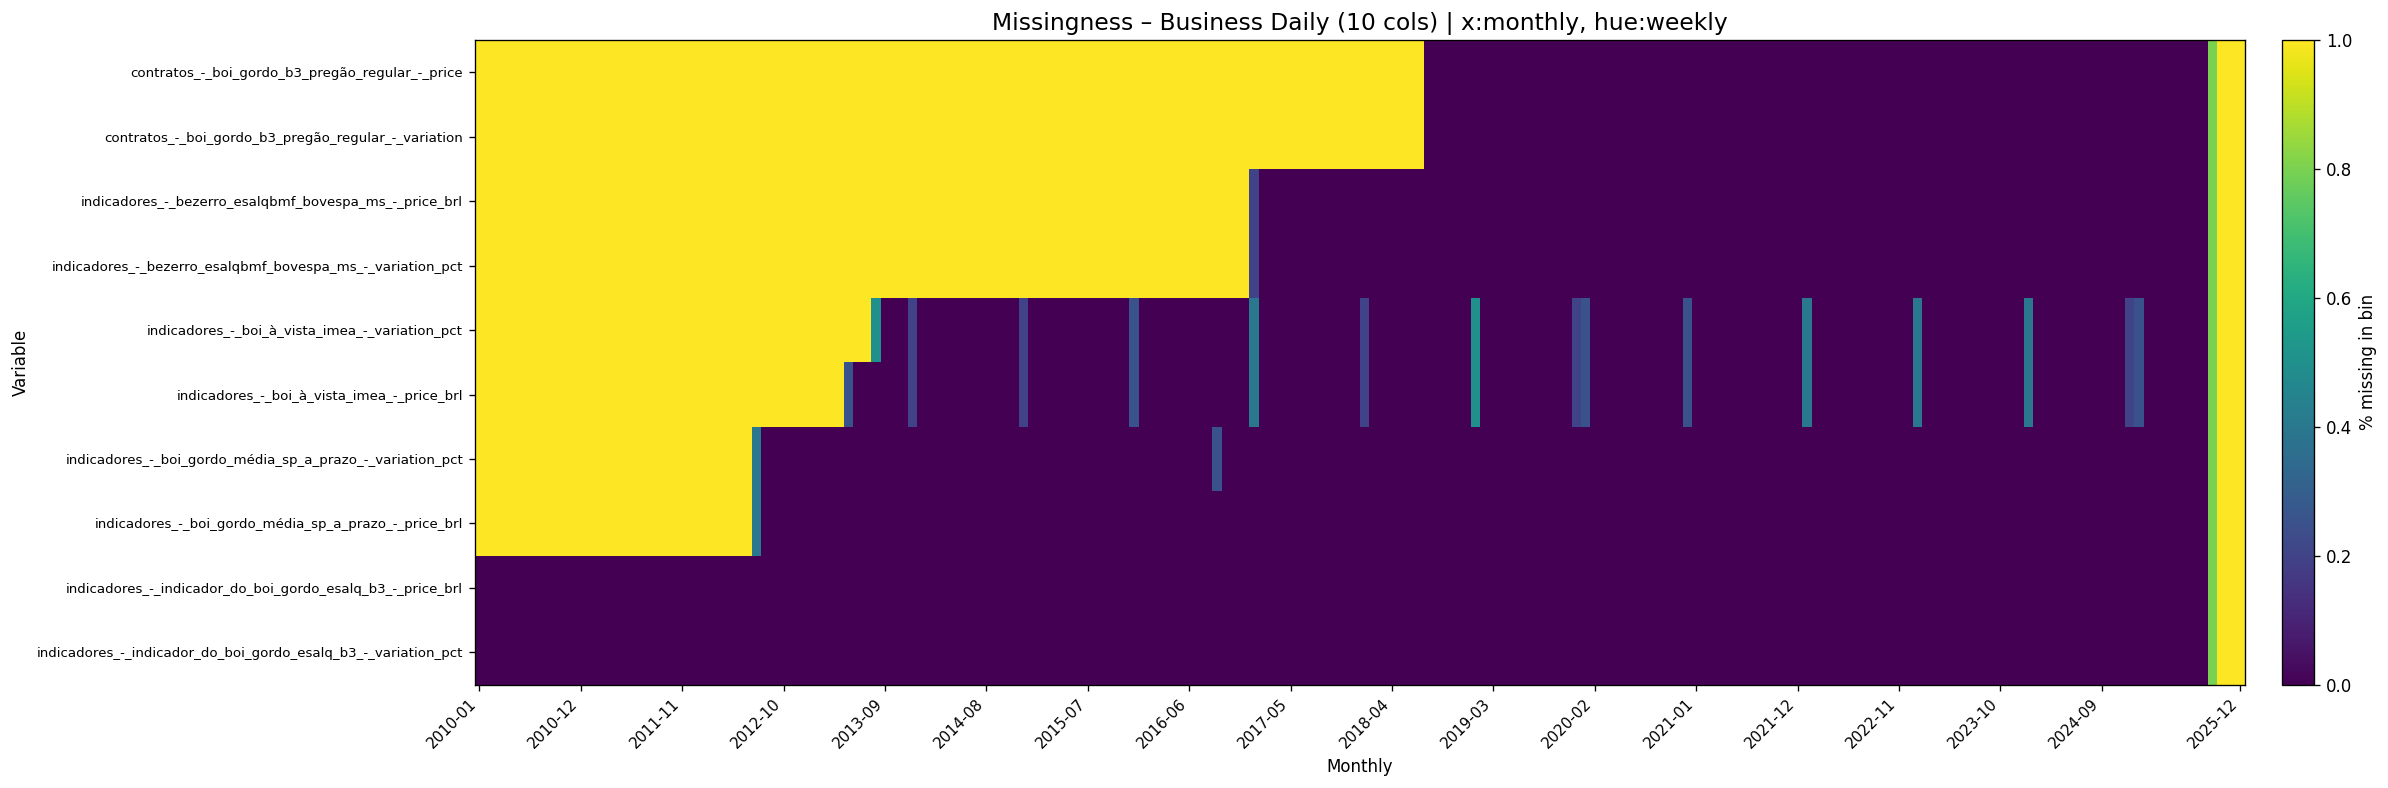

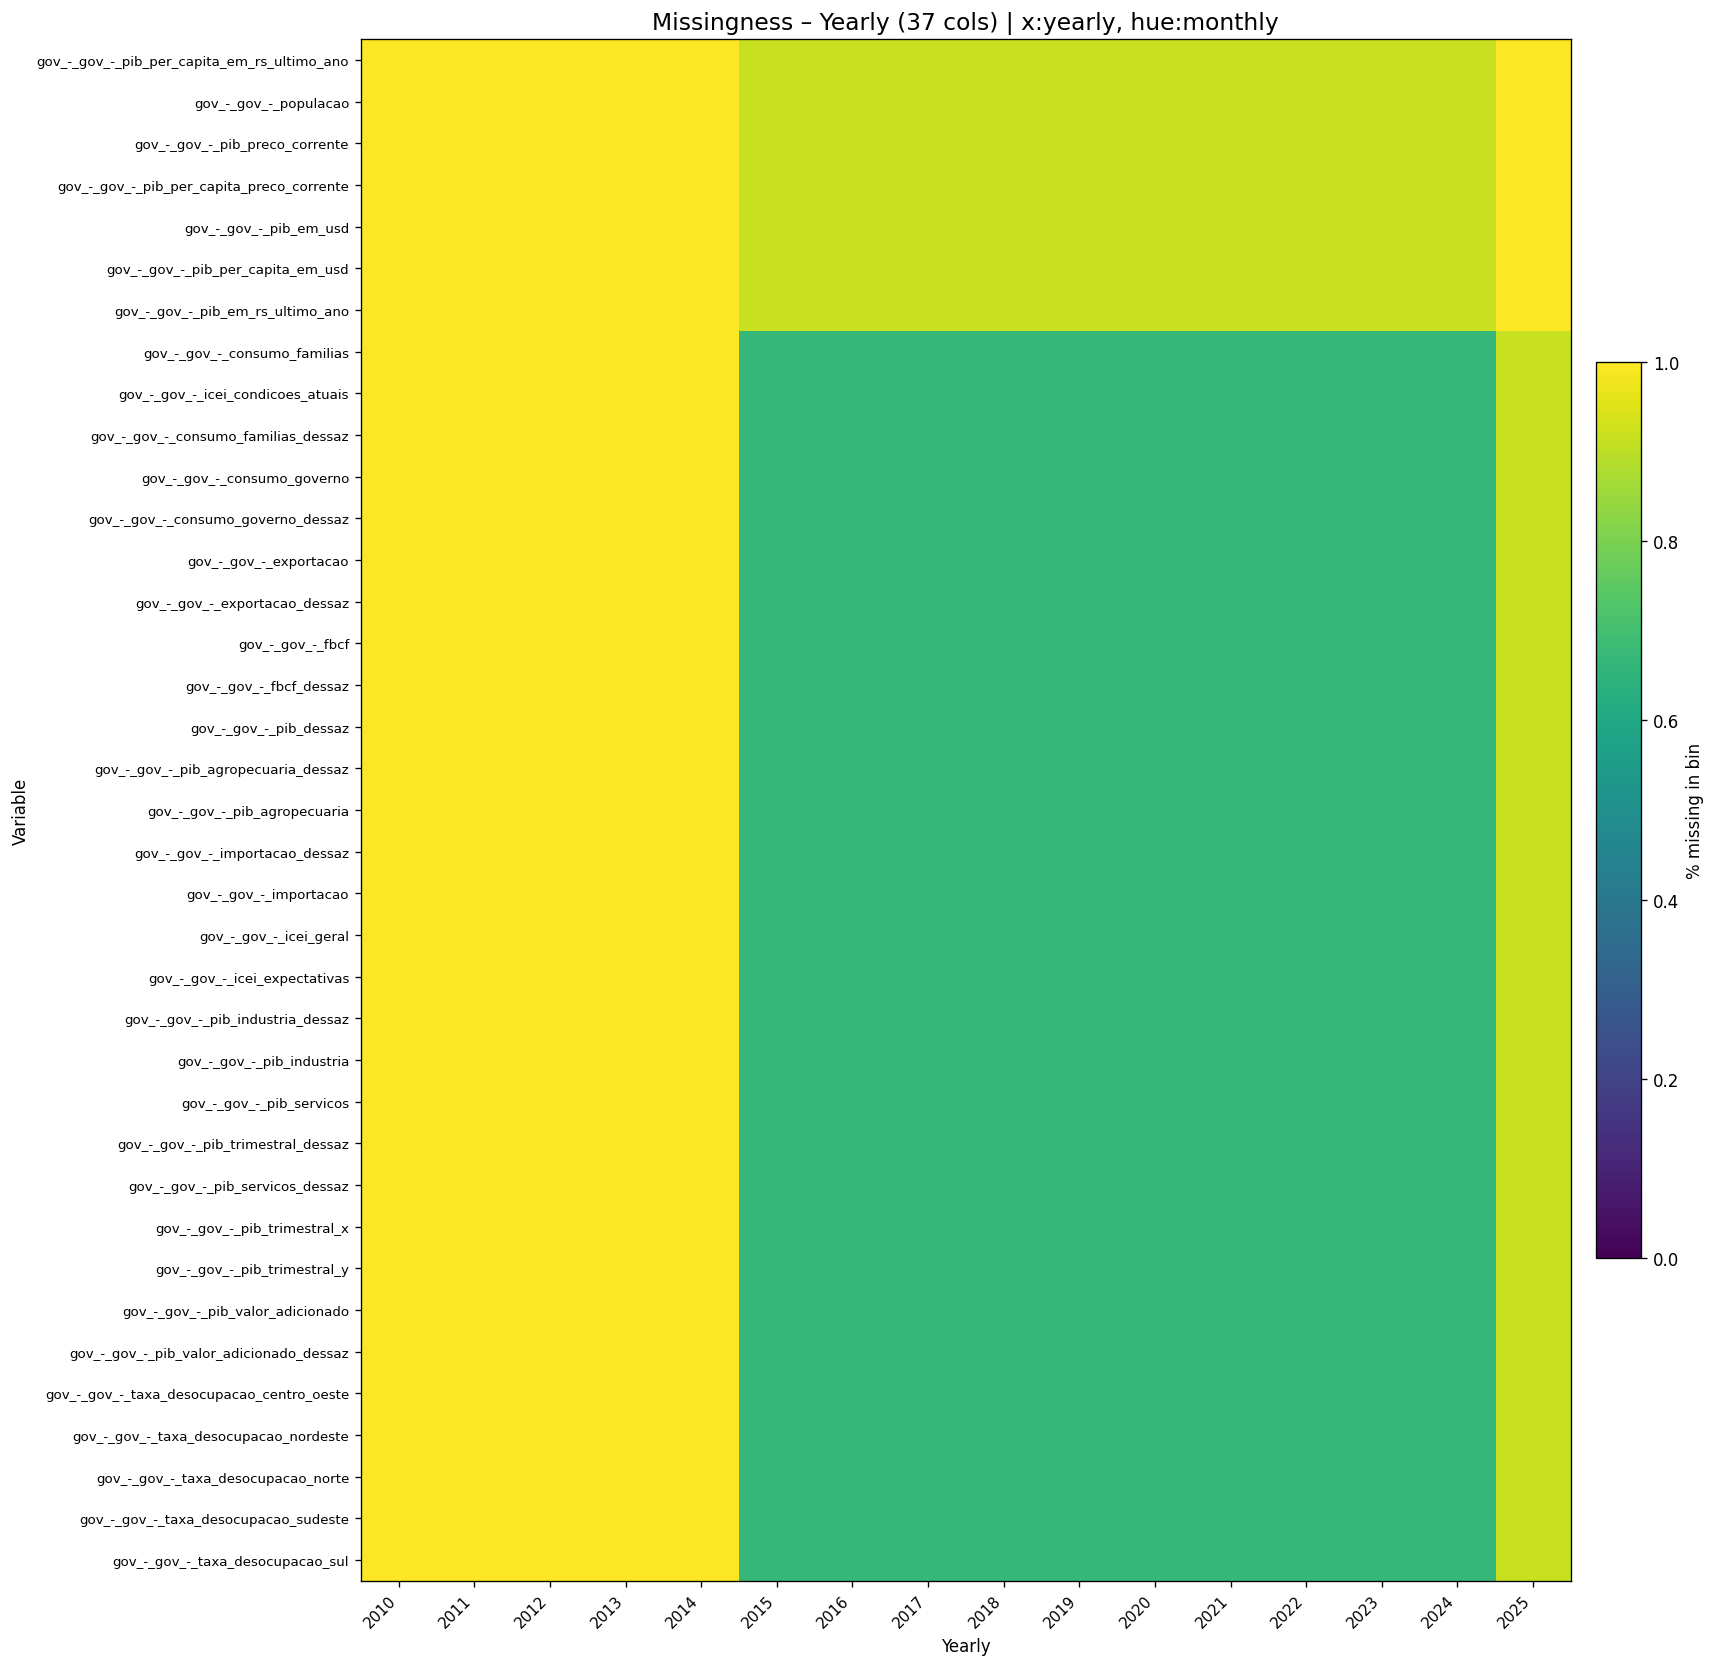

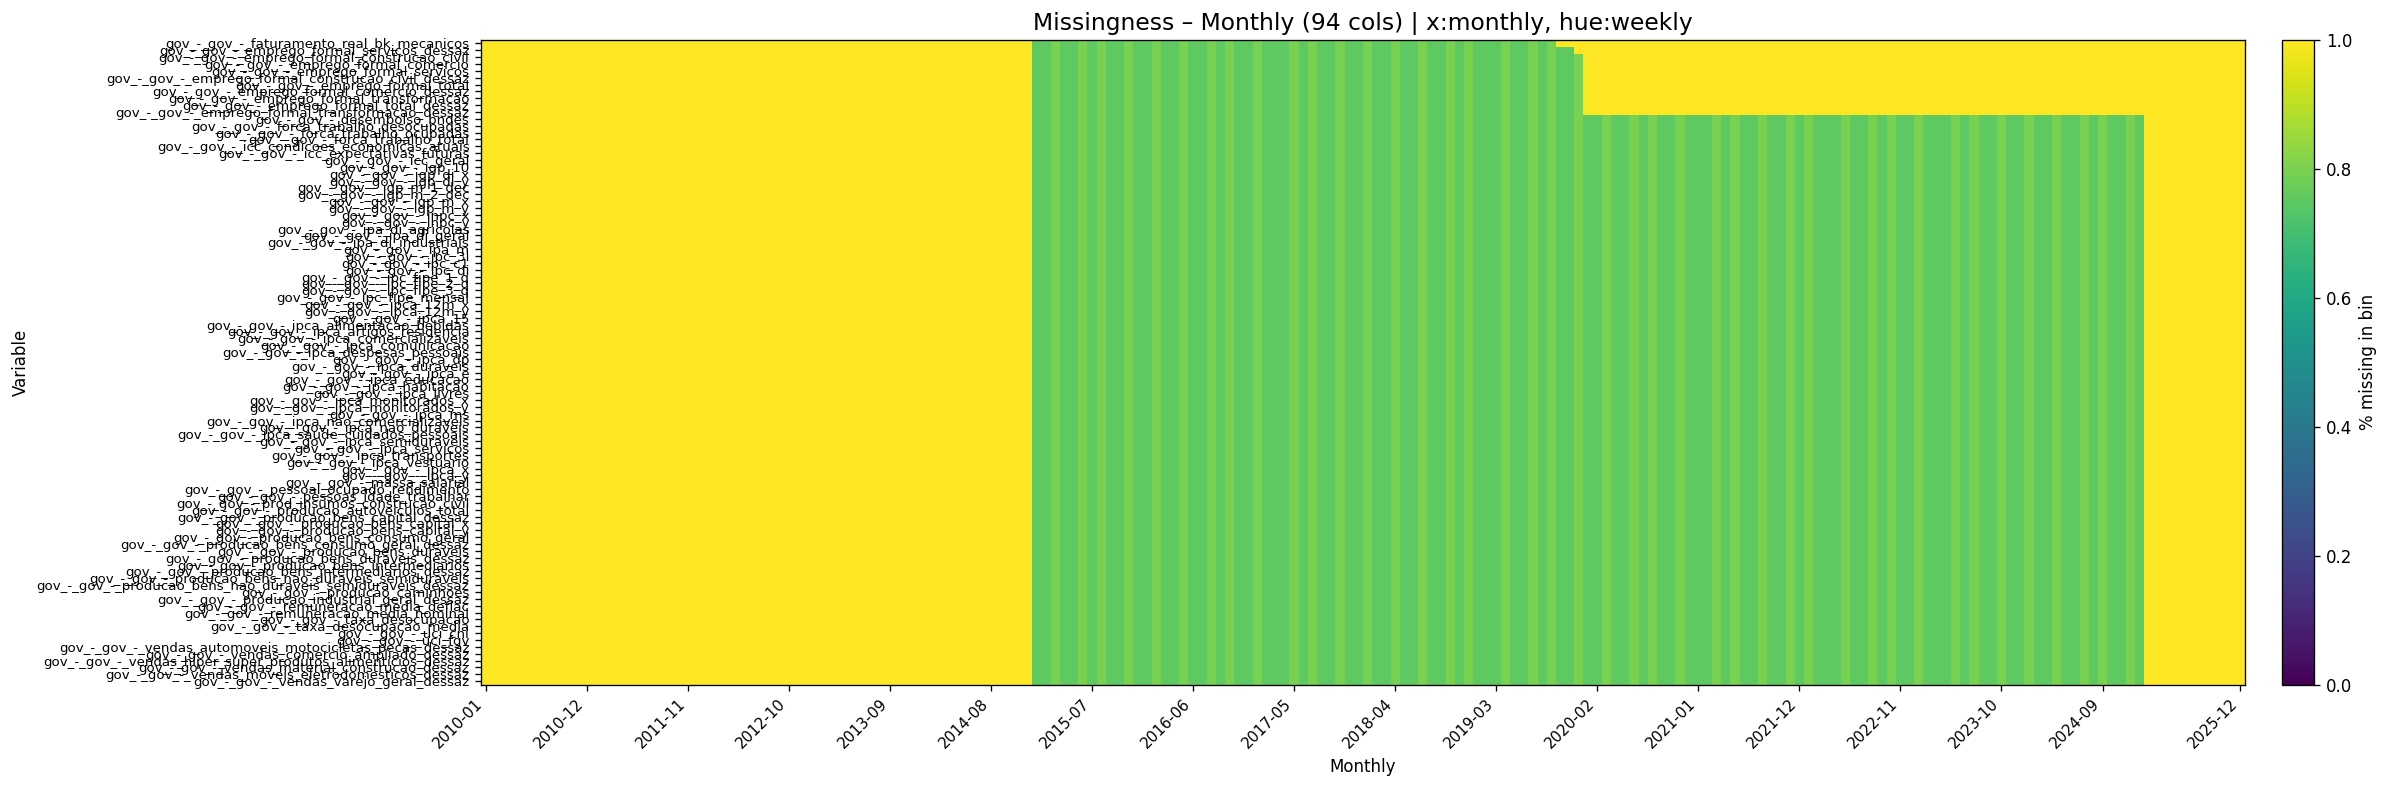

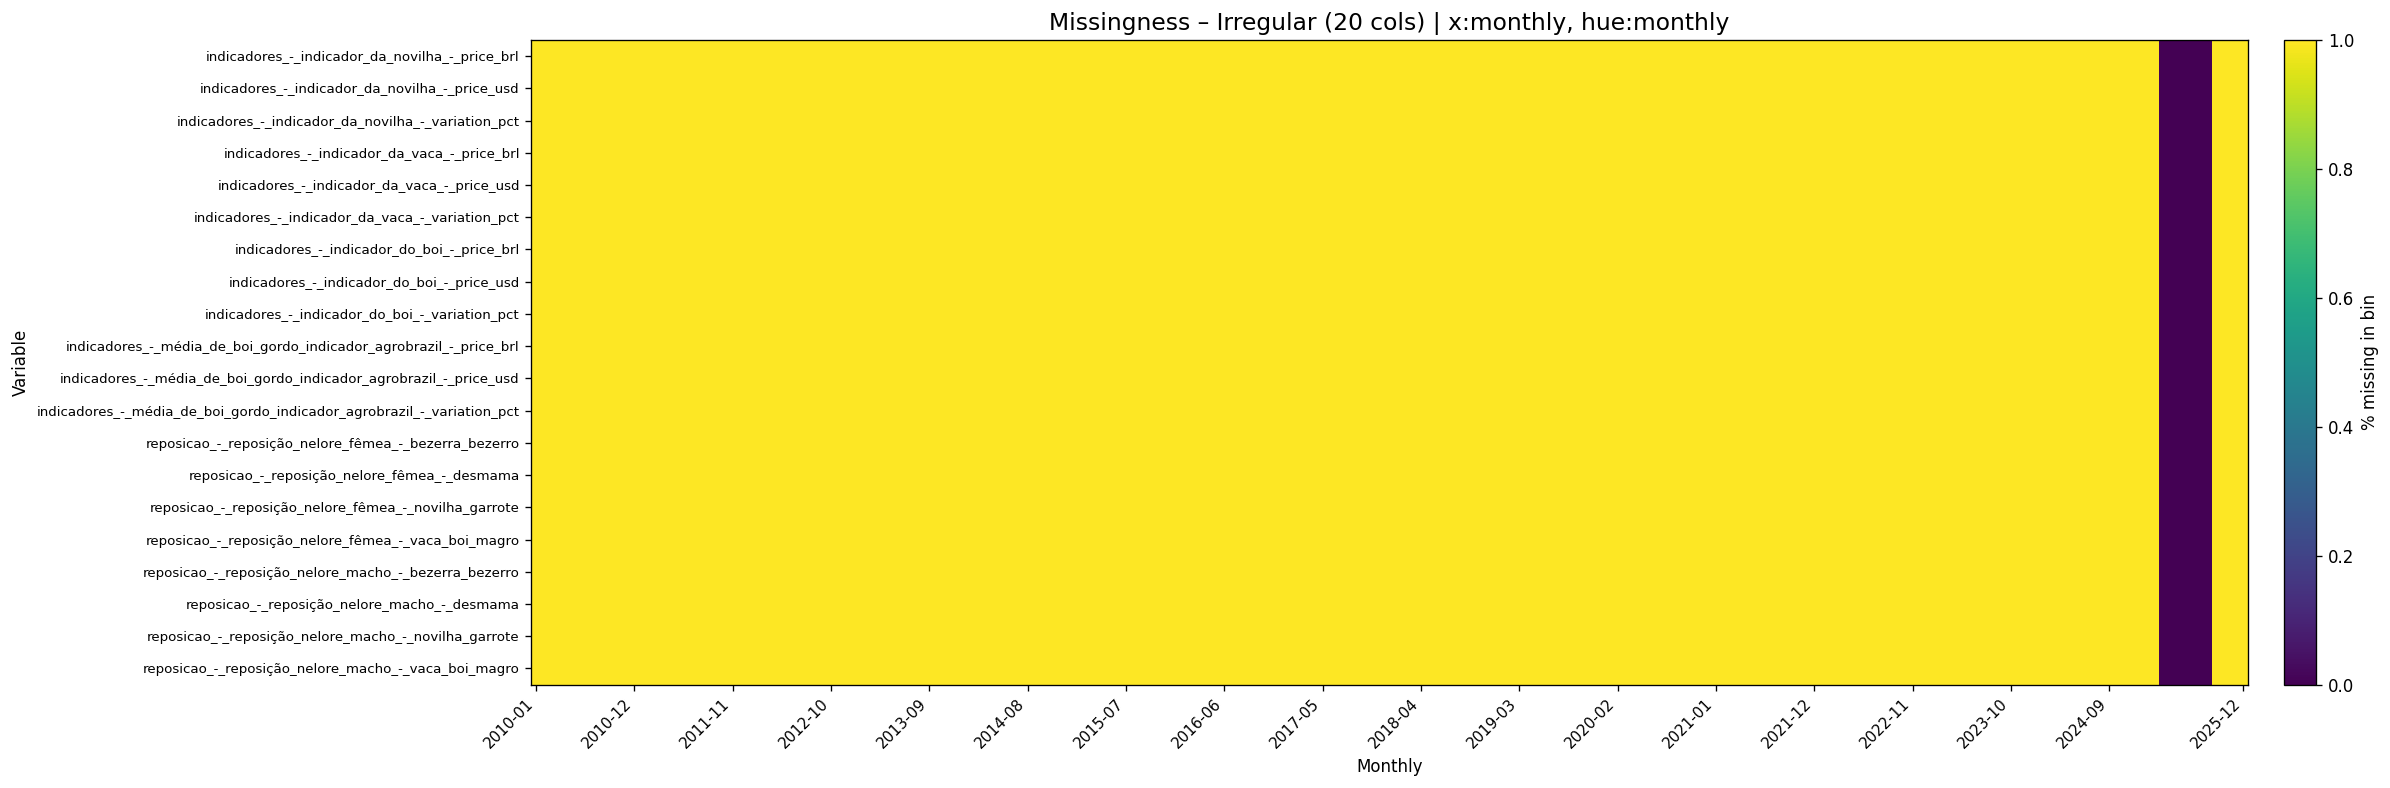

In [4]:
from timeseries.granularity import GranularityManager
from timeseries.missingness import MissingnessExplorer, DEFAULT_GRID_FOR

gm = GranularityManager(X_clean, anchor="JAN")
gmap = gm.infer_map()
gm.save_yaml(gmap, "granularities.yaml")
clusters = gm.clusters(gmap)
X_monthly = gm.resample_all("monthly")

mx = MissingnessExplorer(X_clean, anchor="JAN")
figs = mx.plot_grouped(gmap)
for grp, (_, fig) in figs.items():
    fig.show()


decided to crop from 2014 to 2025

In [5]:
import pandas as pd

def crop_by_year(df: pd.DataFrame, start_date: int, end_date: int) -> pd.DataFrame:
    """
    Return subset of df between start_year and end_year inclusive.
    dates: YYYY-MM-DD
    """
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be a DatetimeIndex.")
    start = pd.Timestamp(f"{start_date}")
    end = pd.Timestamp(f"{end_date}")
    crop = df.loc[(df.index >= start) & (df.index <= end)]
    return crop.dropna(axis=1, how="all")

def make_unique(names):
    seen = {}
    out = []
    for n in names:
        if n not in seen:
            seen[n] = 0
            out.append(n)
        else:
            seen[n] += 1
            out.append(f"{n}__{seen[n]}")
    return out

X_crop = crop_by_year(X_clean, 2014, 2025)
cols = [str(c).split("_-_")[-1] for c in X_crop.columns]

X_crop.columns = make_unique(cols)


re-inspecting missing values

/tmp/ipykernel_603976/701104314.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


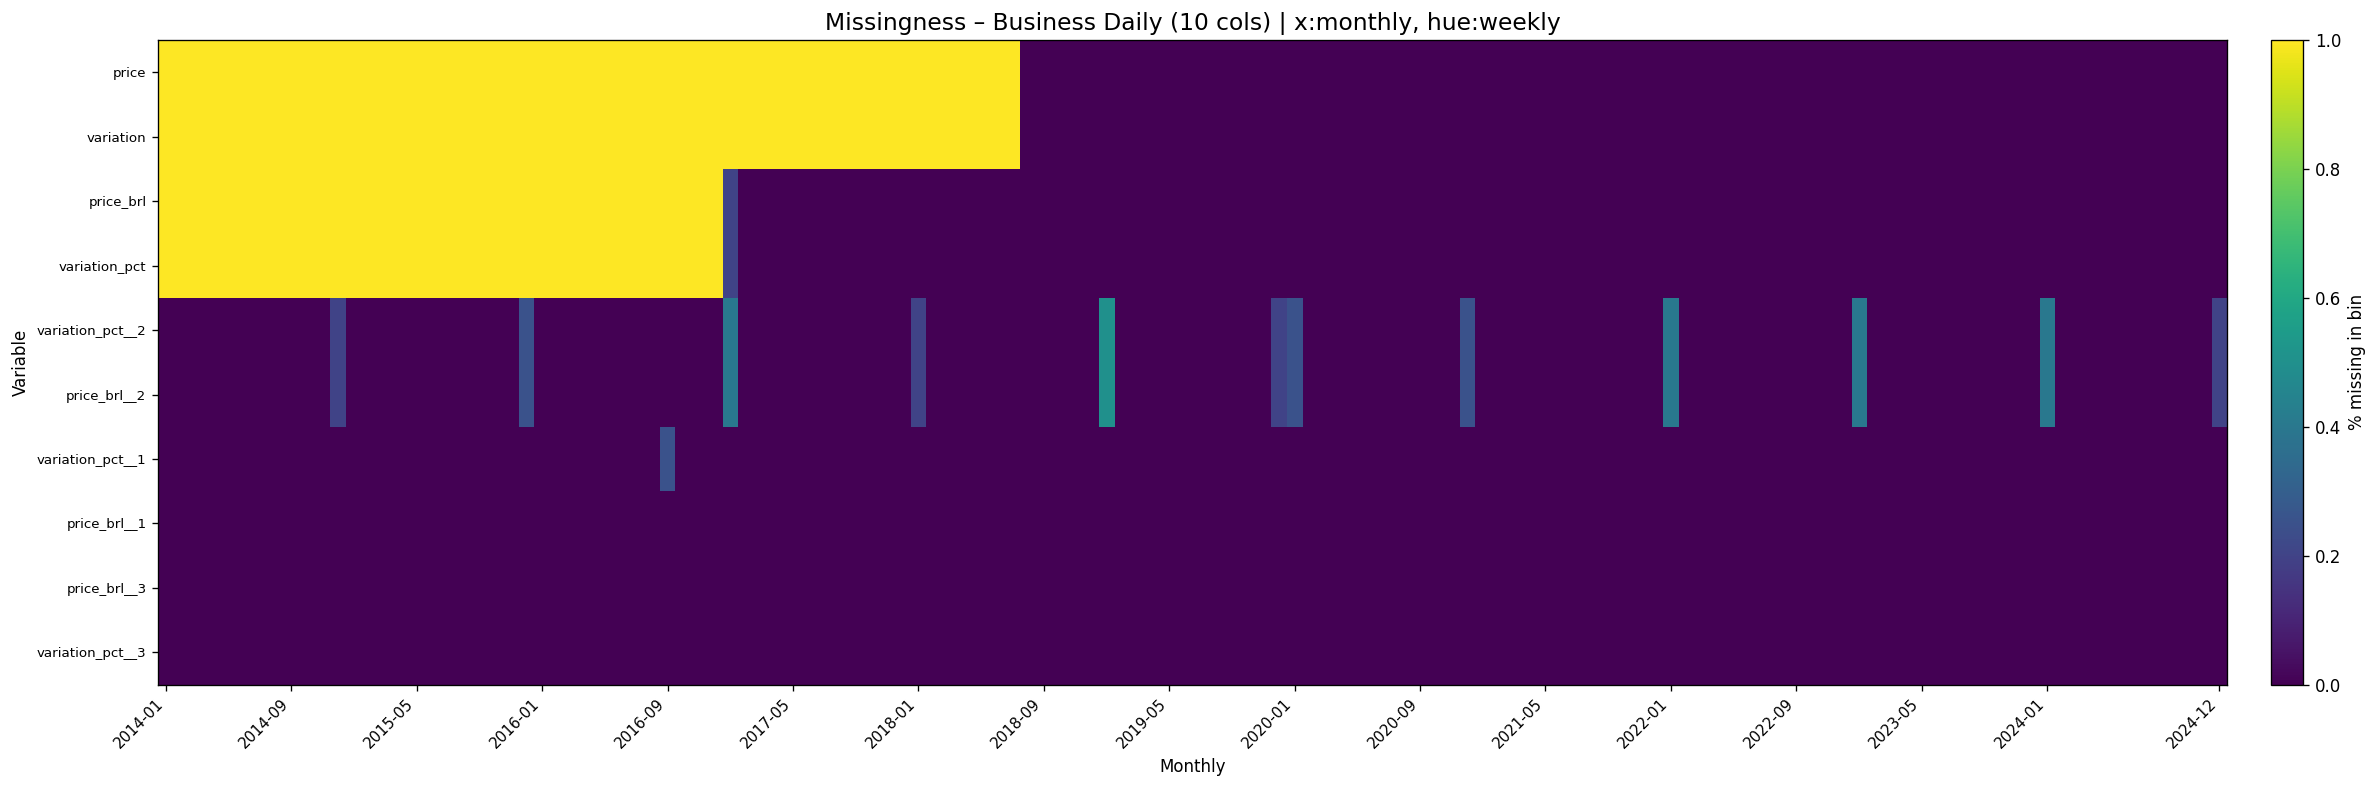

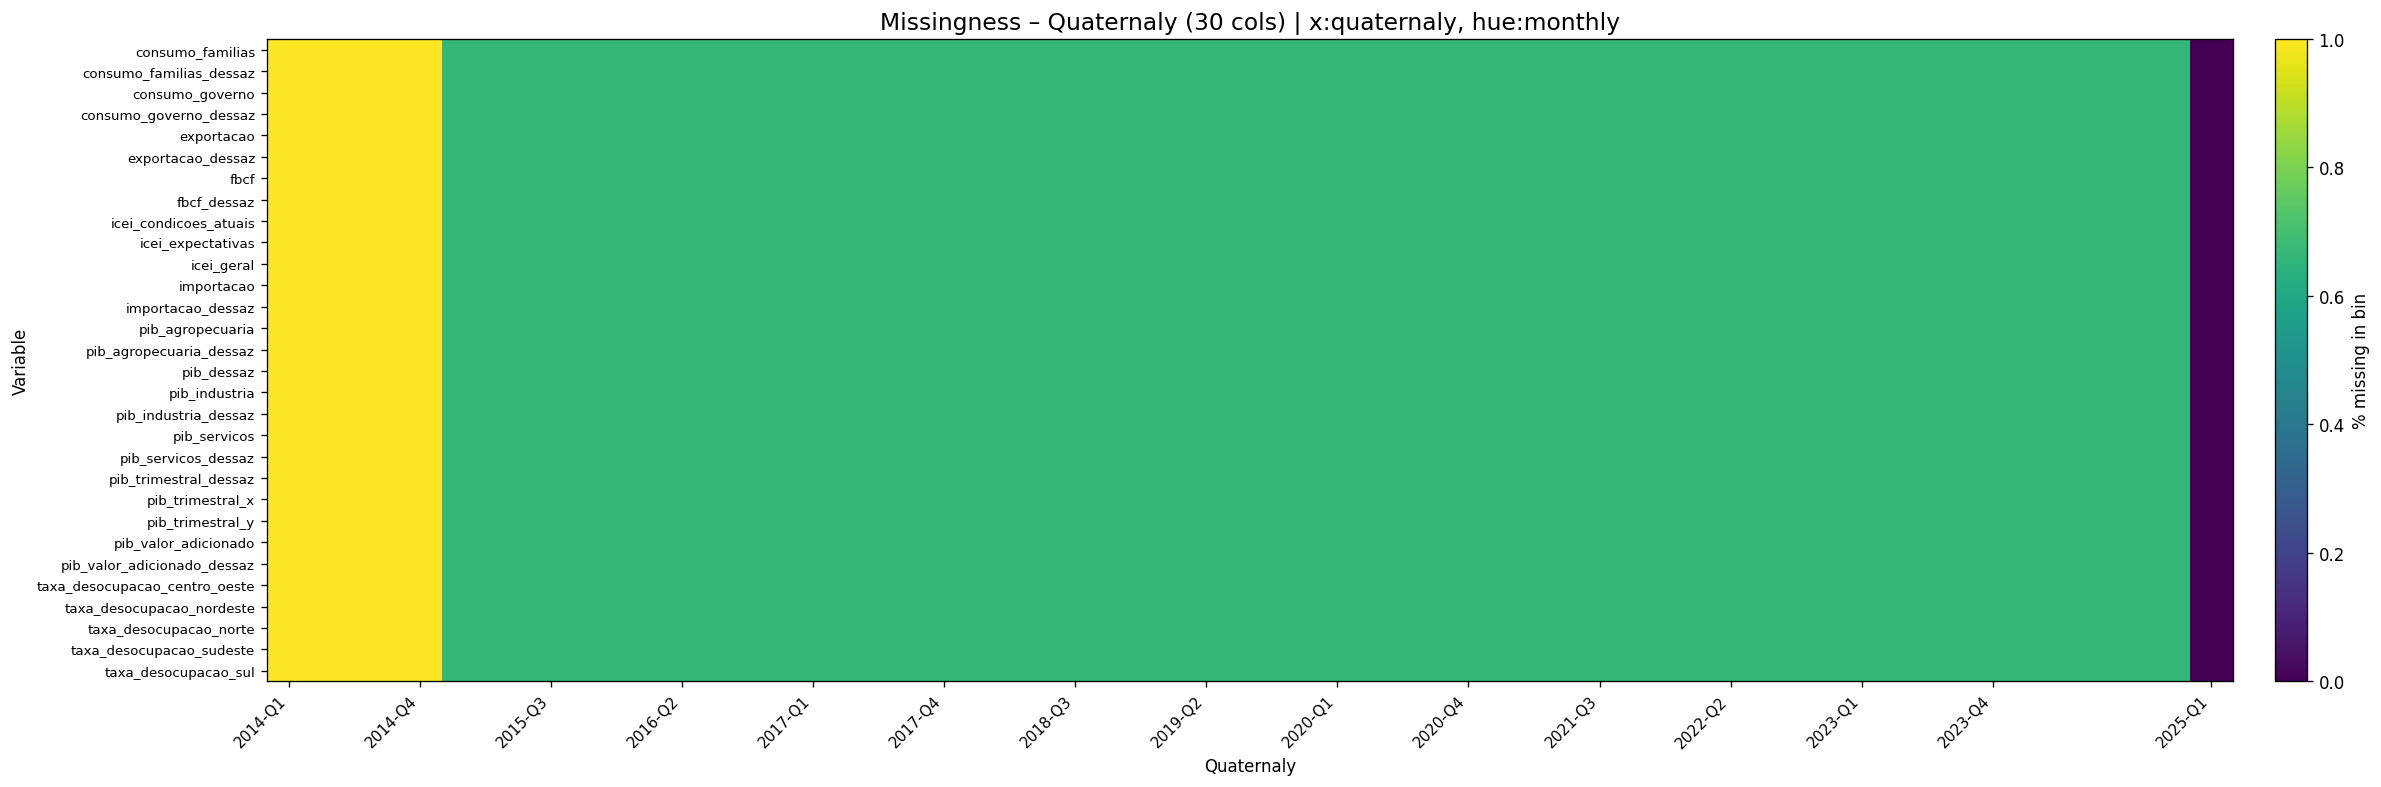

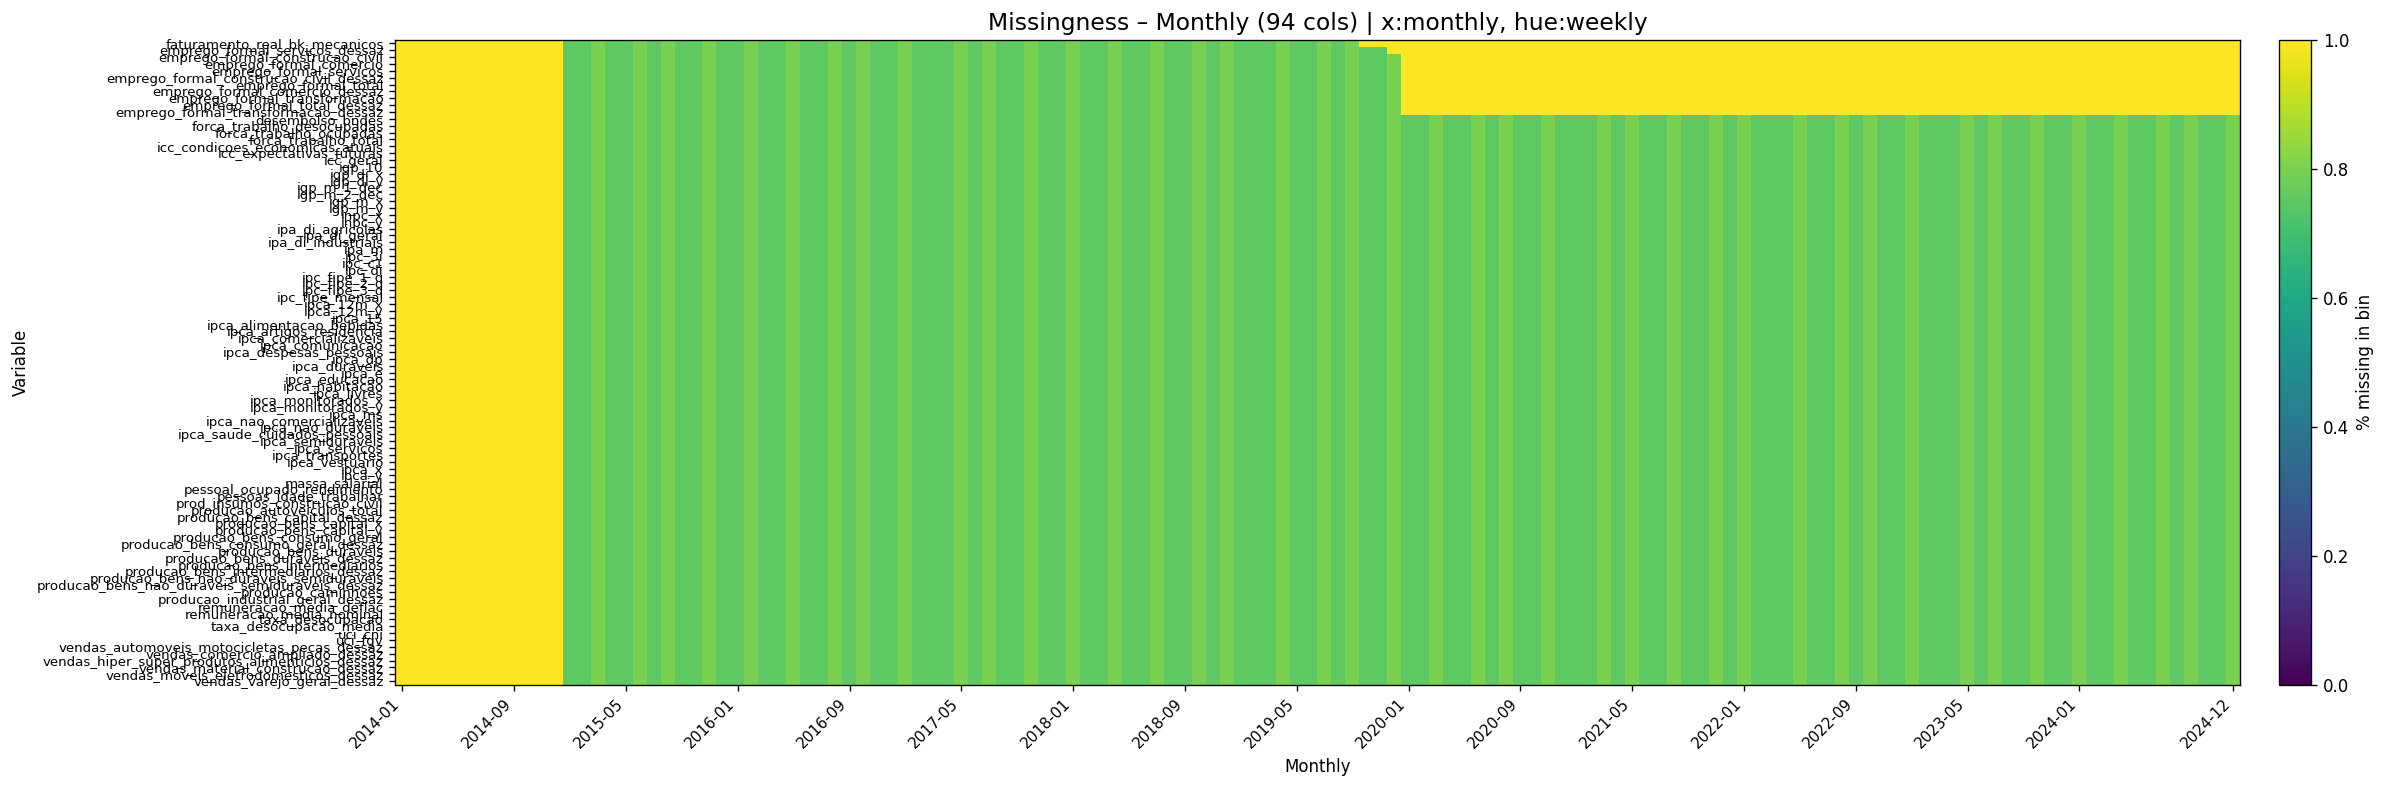

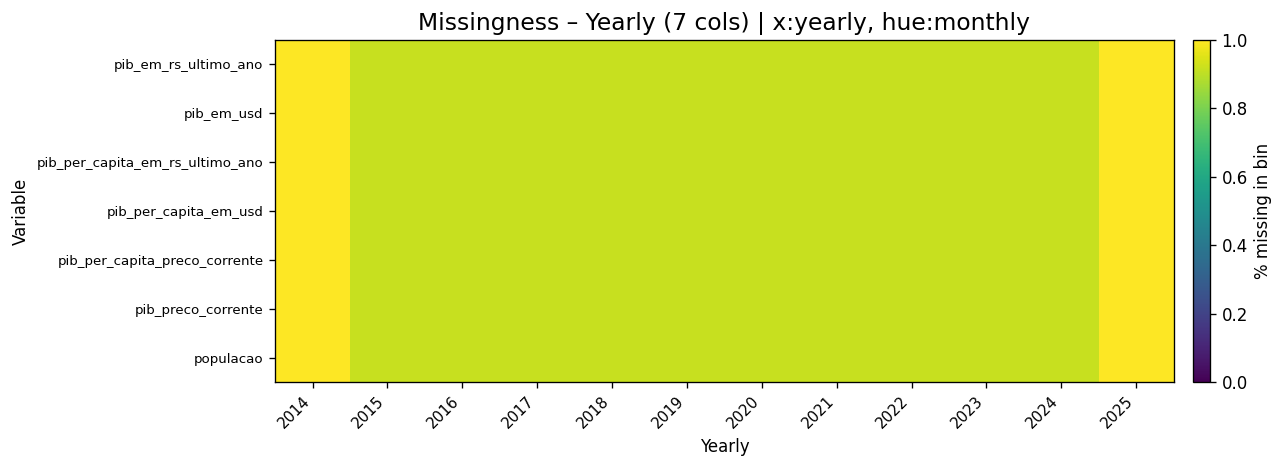

In [6]:


from timeseries.granularity import GranularityManager
from timeseries.missingness import MissingnessExplorer, DEFAULT_GRID_FOR

gm = GranularityManager(X_crop, anchor="JAN")
gmap = gm.infer_map()
gm.save_yaml(gmap, "granularities.yaml")
clusters = gm.clusters(gmap)
X_monthly = gm.resample_all("monthly")

mx = MissingnessExplorer(X_crop, anchor="JAN")
figs = mx.plot_grouped(gmap)
for grp, (_, fig) in figs.items():
    fig.show()


In [7]:

import pandas as pd

def summarize_missing(df: pd.DataFrame) -> None:
    """Print count and percent of missing values per column."""
    miss = df.isna().sum()
    pct = miss / len(df) * 100
    out = pd.DataFrame({"missing": miss, "percent": pct}).query("missing > 0")
    print(out.sort_values("percent", ascending=False).to_string(float_format="%.2f"))


summarize_missing(X_crop)

                                                 missing  percent
pib_per_capita_em_usd                               4009    99.75
pib_em_usd                                          4009    99.75
pib_em_rs_ultimo_ano                                4009    99.75
populacao                                           4009    99.75
pib_per_capita_preco_corrente                       4009    99.75
pib_preco_corrente                                  4009    99.75
pib_per_capita_em_rs_ultimo_ano                     4009    99.75
exportacao_dessaz                                   3978    98.98
consumo_familias                                    3978    98.98
consumo_governo                                     3978    98.98
consumo_familias_dessaz                             3978    98.98
consumo_governo_dessaz                              3978    98.98
importacao                                          3978    98.98
taxa_desocupacao_nordeste                           3978    98.98
pib_servic

## Correlations

In [8]:
from timeseries.granularity import GranularityManager

gm = GranularityManager(X_crop, anchor="JAN")
gmap = gm.infer_map()
by_g = gm.group_frames(gmap)  # Dict[Granularity, pd.DataFrame]

for key, df in by_g.items():
    print(f"{key}: {len(df.columns)} columns")


business_daily: 10 columns
quaternaly: 30 columns
monthly: 94 columns
yearly: 7 columns


In [9]:
summarize_missing(by_g.get("business_daily"))

                  missing  percent
price                1196    41.66
variation            1196    41.66
price_brl             788    27.45
variation_pct         788    27.45
variation_pct__2        3     0.10
price_brl__2            3     0.10
variation_pct__1        2     0.07
price_brl__1            2     0.07
price_brl__3            2     0.07
variation_pct__3        2     0.07


### per granularity clusters

business_daily
quaternaly
monthly
yearly


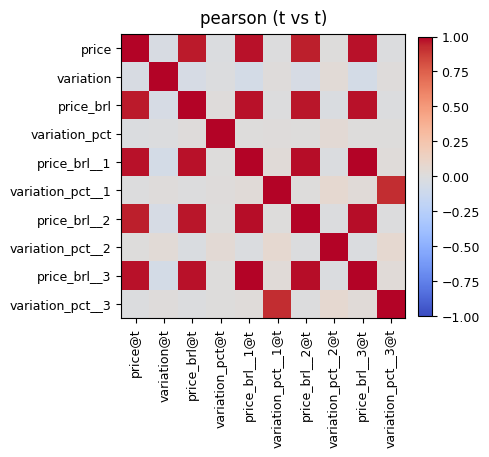

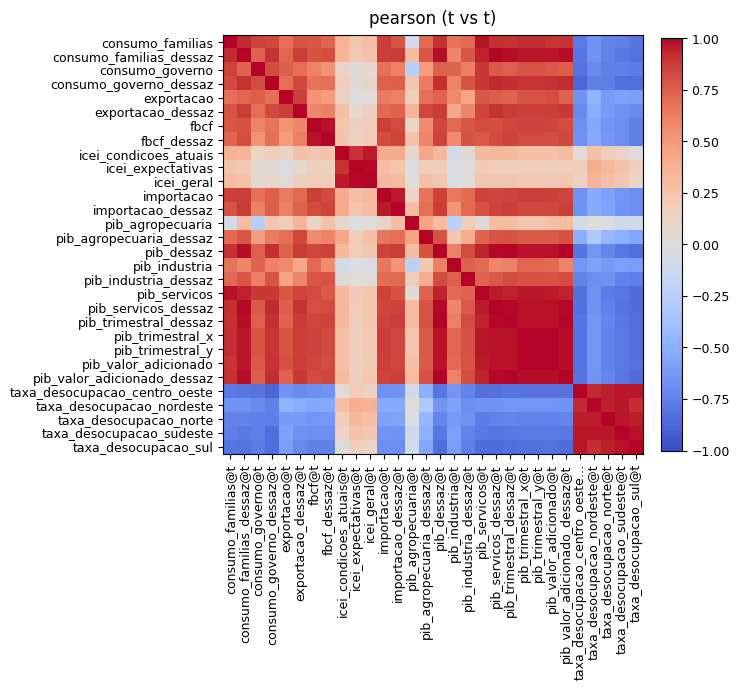

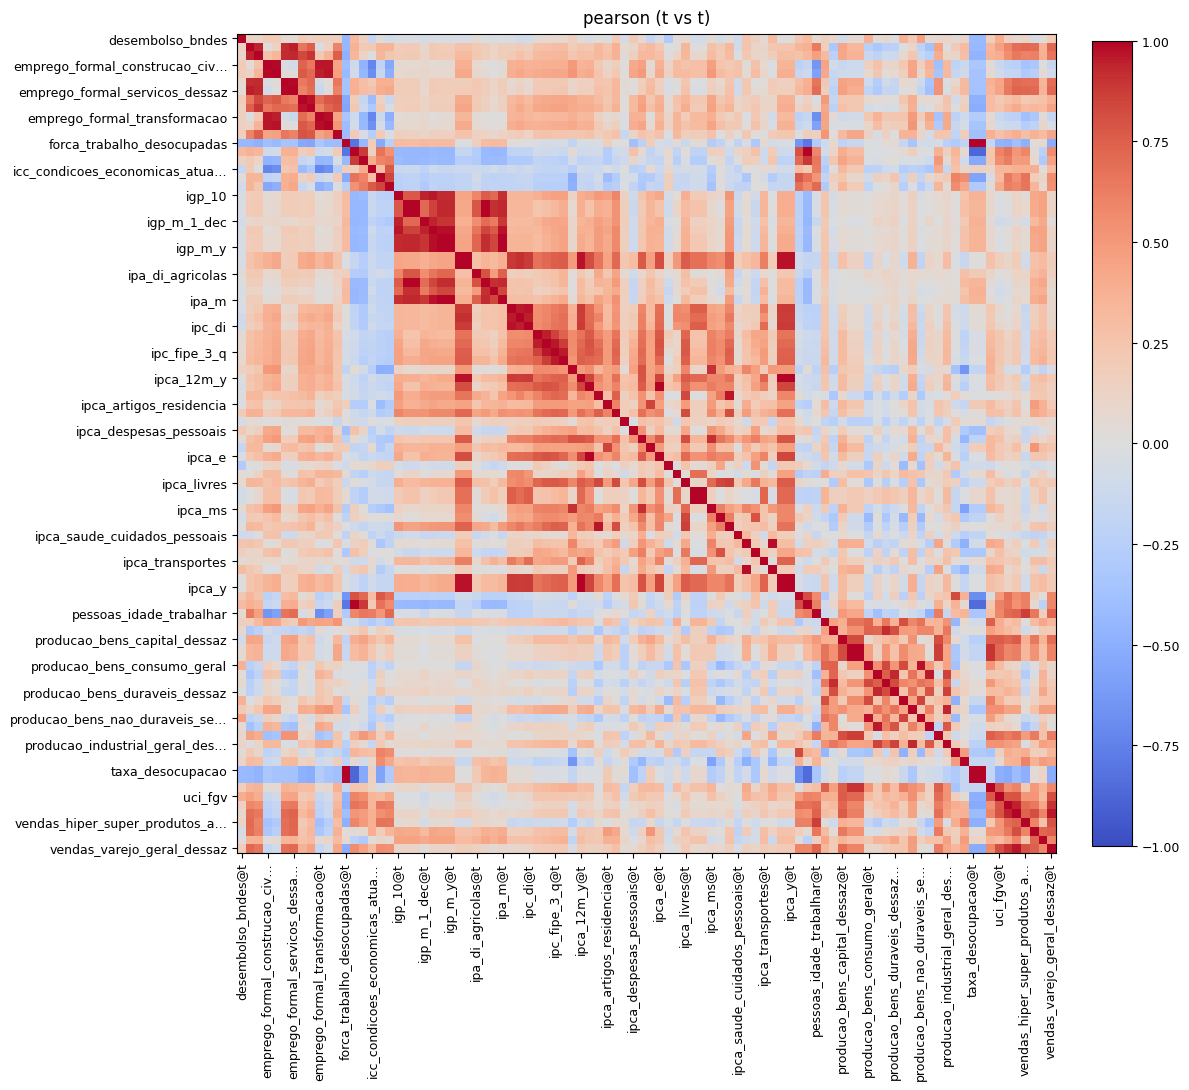

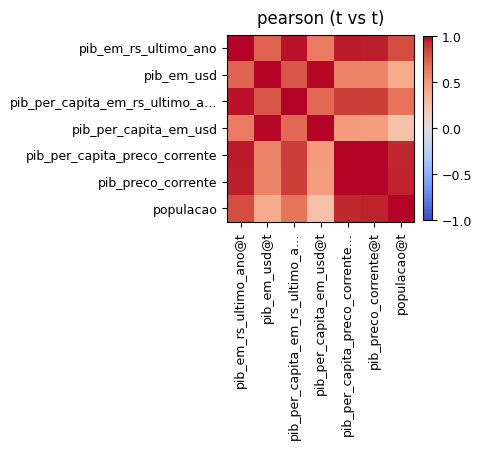

In [10]:

from timeseries.corr import Correlator
import pandas as pd

granularities = ["business_daily", "quaternaly", "monthly", "yearly"]
lags = [None, pd.DateOffset(days=1), pd.DateOffset(days=7), pd.DateOffset(months=1)]

for granularity in granularities:
    print(f"{granularity}")
    corr = Correlator(
        by_g.get(granularity), 
        index_freq="D", 
        align="asof", 
        asof_tolerance=pd.Timedelta("1D")
        )

    res = corr.run_single(metric="pearson", lag=lags[0])
    figs = corr.plot(res)


### per correlation metric

metrics: ['pearson', 'spearman', 'kendall', 'energy_dist', 'wasserstein']


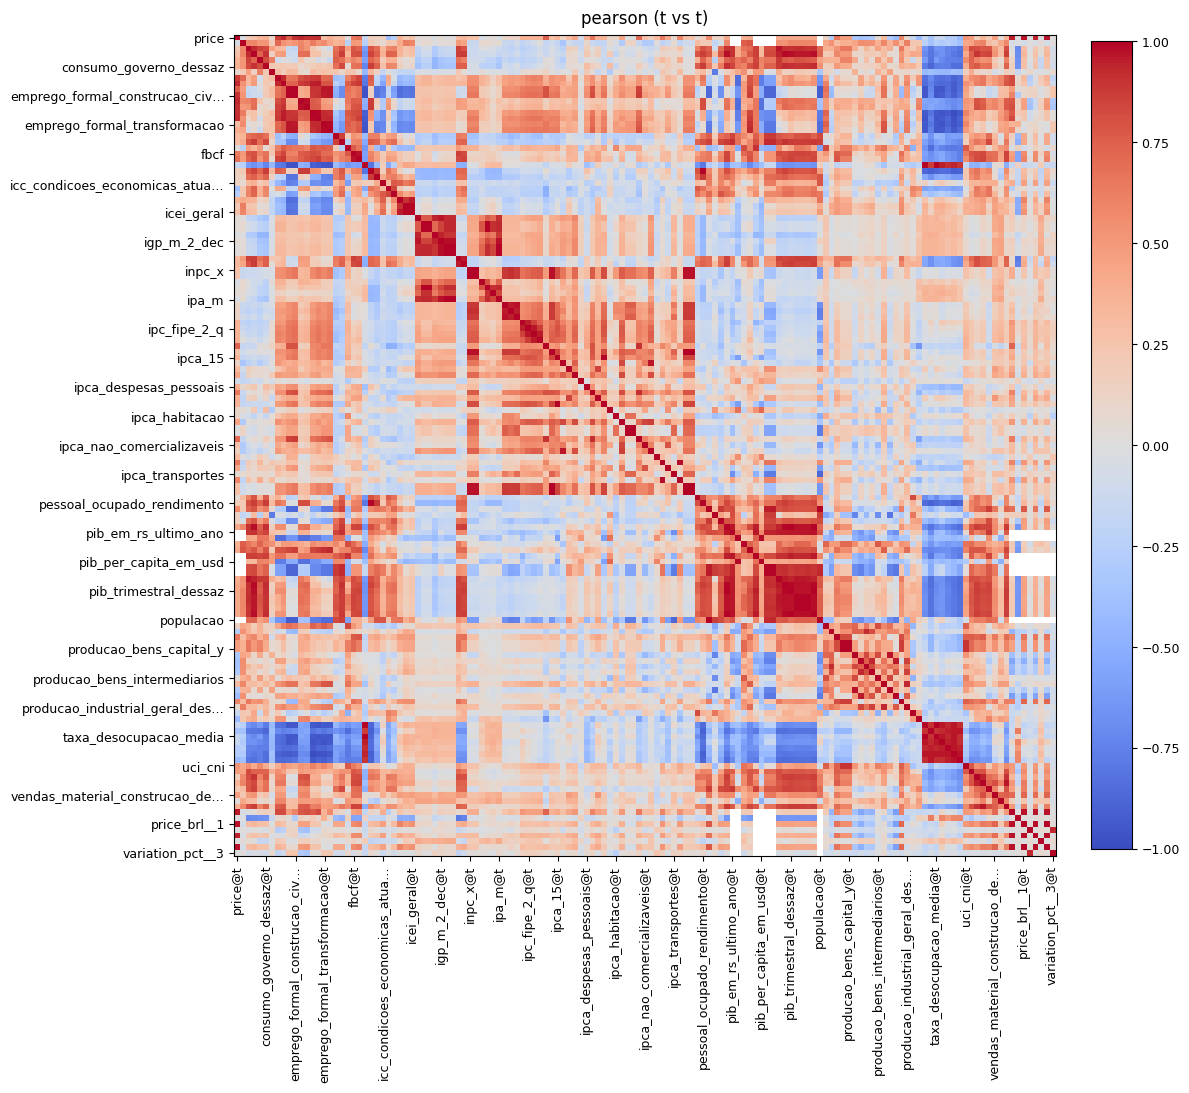

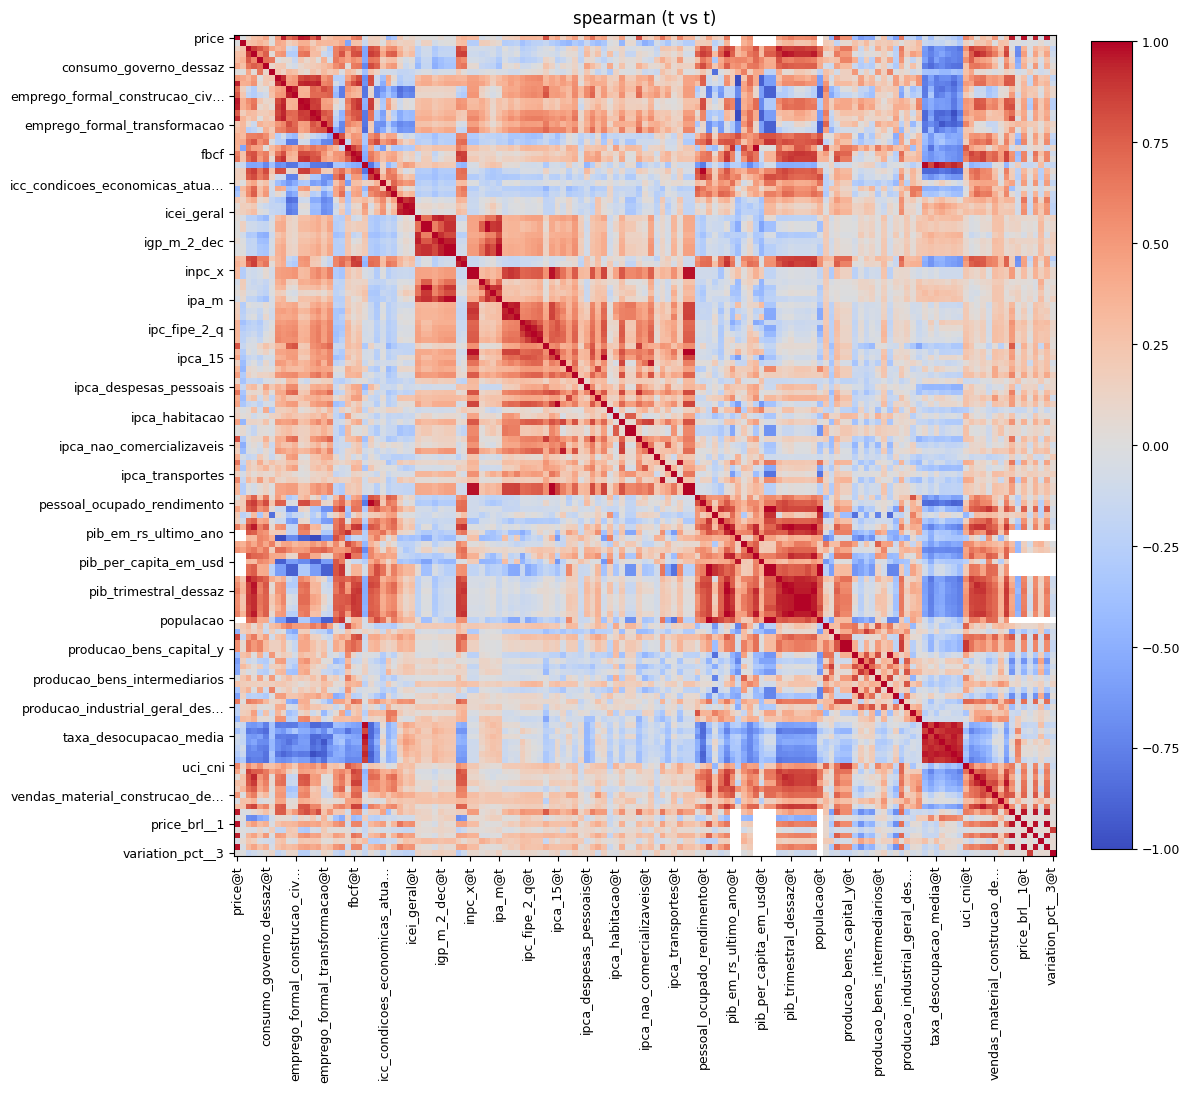

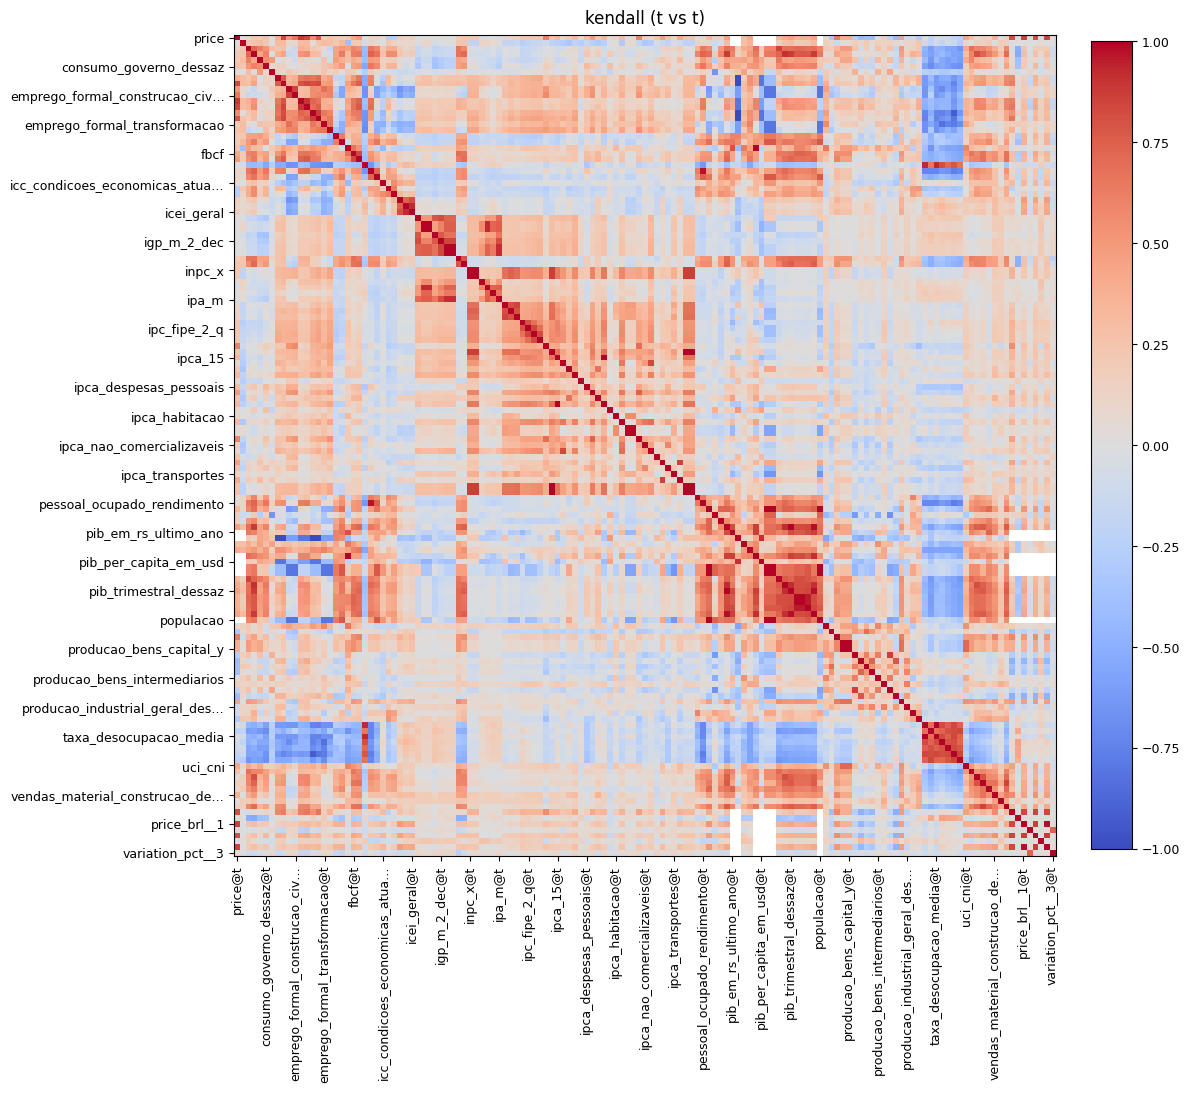

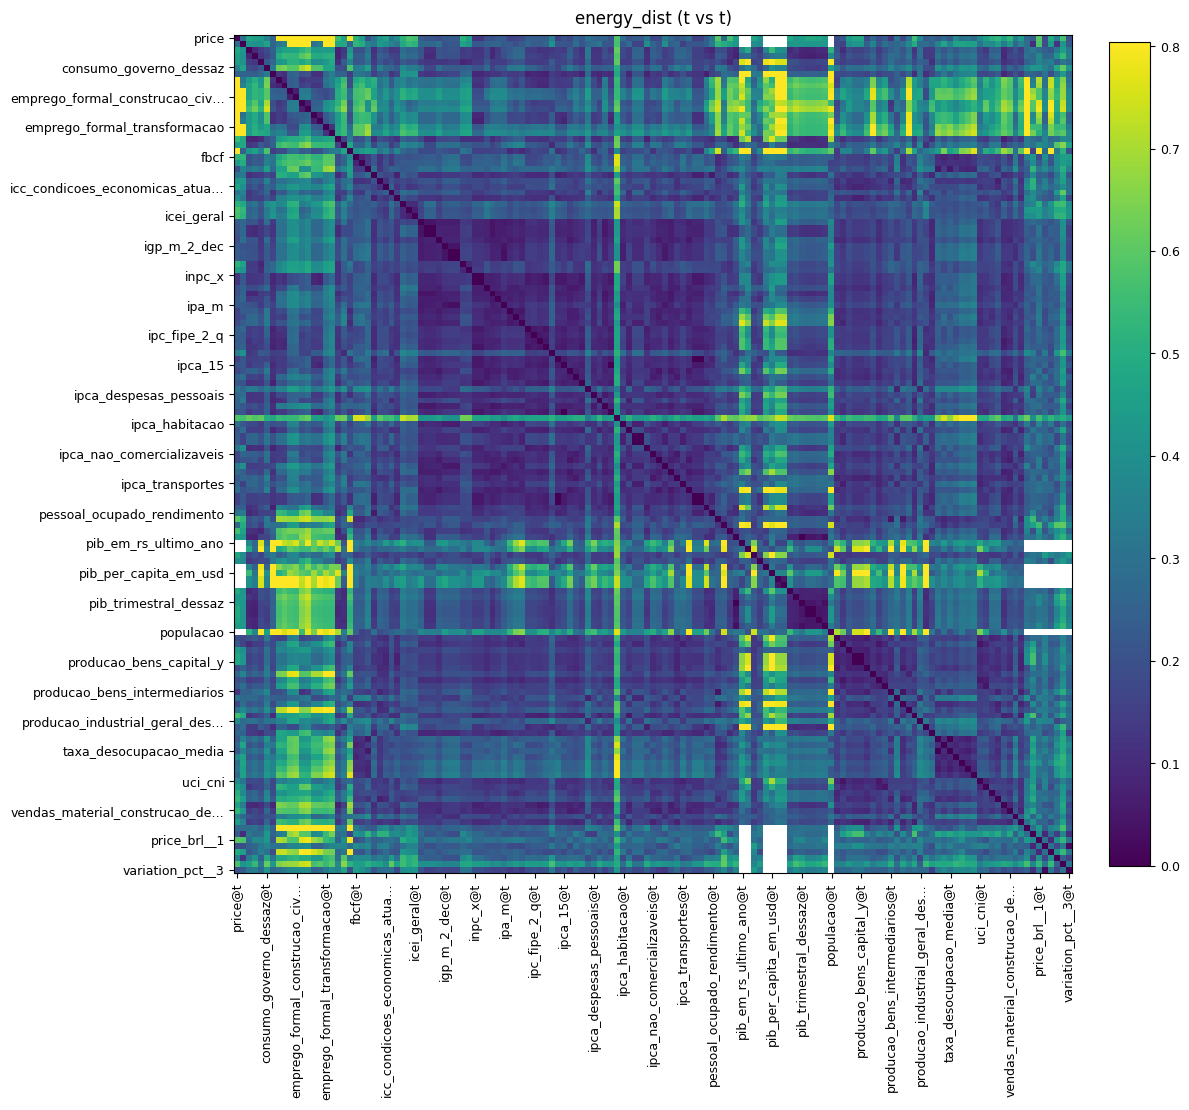

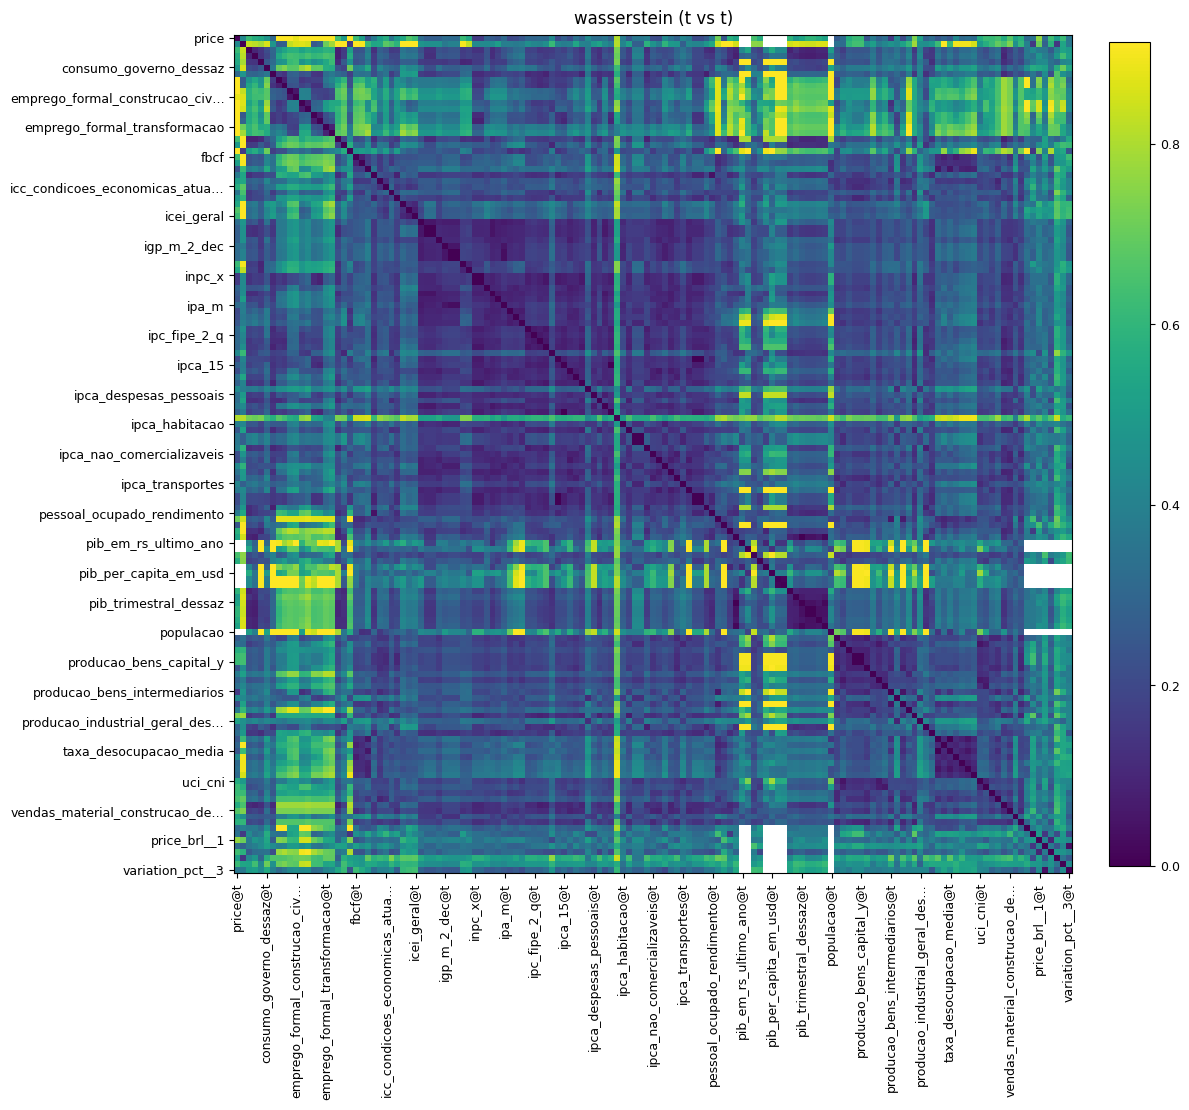

In [11]:
from timeseries.corr import Correlator, available_metrics
print("metrics:", available_metrics())

corr = Correlator(X_crop, align="asof", asof_tolerance=pd.Timedelta("1D"))
for m in available_metrics():
    res = corr.run_single(metric=m, lag=None)
    corr.plot(res)
    

### per-lags

In [12]:
from timeseries.corr import Correlator, CorrResult, available_metrics
print("metrics:", available_metrics())

lags = [
    None, 
    pd.DateOffset(days=1), 
    pd.DateOffset(days=7), 
    pd.DateOffset(months=1)
    ]

corr = Correlator(X_crop, align="asof", asof_tolerance=pd.Timedelta("1D"))
corr_results: Dict[str, Dict[str, CorrResult]] = corr.run_all(lags)
    
for key, value in corr_results.items():
    print(f"{key}: {value}")


metrics: ['pearson', 'spearman', 'kendall', 'energy_dist', 'wasserstein']
pearson: {'0': CorrResult(metric_name='pearson', lag=None, matrix=                          price@t  variation@t  consumo_familias@t  \
price                    1.000000    -0.036729            0.197122   
variation               -0.036729     1.000000            0.587952   
consumo_familias         0.197122     0.587952            1.000000   
consumo_familias_dessaz  0.259597     0.584639            0.922298   
consumo_governo          0.347037     0.513700            0.855543   
...                           ...          ...                 ...   
variation_pct__1        -0.011218     0.012410           -0.023358   
price_brl__2             0.943316    -0.048542            0.214522   
variation_pct__2        -0.014084     0.041540            0.063174   
price_brl__3             0.974285    -0.064889            0.292164   
variation_pct__3        -0.007483     0.012769           -0.085738   

                   

### aggregation

all metrics and lags normalized by average percentile:
$$R_{ij} = \frac{1}{K} \sum\limits_{k} \text{percentile}_{k}(v_{ij}^{(k)})$$

higher $R_{ij}$ means pair consistently strong relative to its own metric's scale.

/tmp/ipykernel_603976/1770508292.py:58: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  M.stack(dropna=True)


| Top positive                                   | Top negative                                            | Most uncorrelated                                                       |
|:-----------------------------------------------|:--------------------------------------------------------|:------------------------------------------------------------------------|
| emprego_formal_comercio_dessaz × price         | fbcf × taxa_desocupacao_centro_oeste                    | producao_bens_consumo_geral × variation_pct__2                          |
| emprego_formal_servicos_dessaz × price         | taxa_desocupacao_centro_oeste × fbcf                    | price_brl__2 × ipa_m                                                    |
| price × emprego_formal_comercio_dessaz         | taxa_desocupacao_nordeste × fbcf                        | vendas_moveis_eletrodomesticos_dessaz × icc_condicoes_economicas_atuais |
| price × emprego_formal_servicos_dessaz         | fbcf × taxa_desocupacao_nordeste  

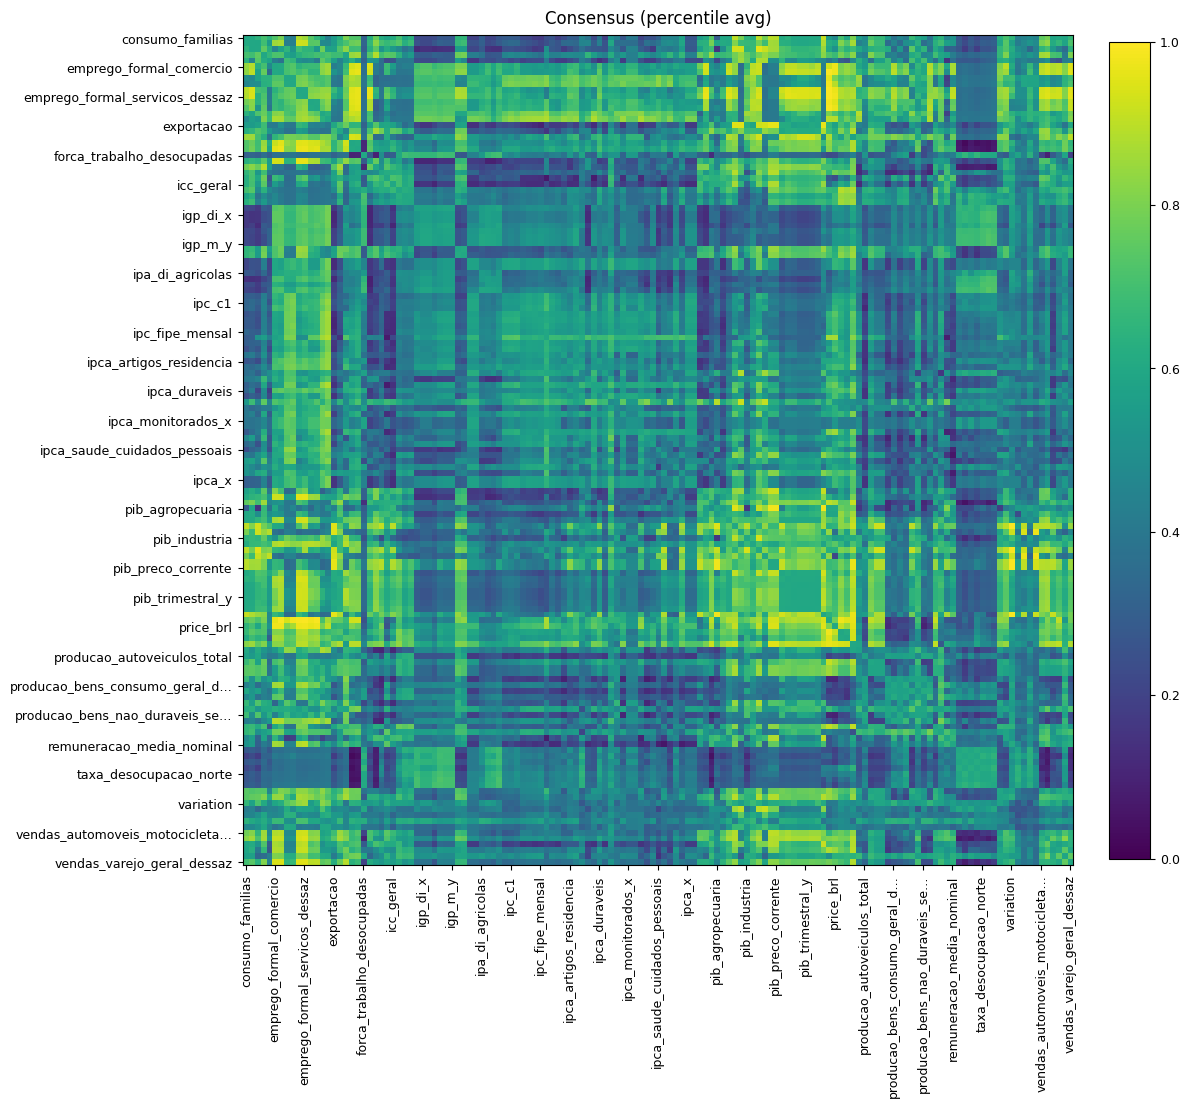

In [ ]:
import re
import numpy as np
import pandas as pd
from typing import Dict, Optional, Tuple, List
from timeseries.corr.types import CorrResult
from timeseries.corr.plot import PlotConfig, plot_heatmap

_strip_pat = re.compile(r"@t.*$")

def _percentilize(M: pd.DataFrame) -> pd.DataFrame:
    v = M.to_numpy().ravel()
    m = ~np.isnan(v)
    r = pd.Series(v[m]).rank(method="average", pct=True).to_numpy()
    out = np.full_like(v, np.nan, dtype=float)
    out[m] = r
    return pd.DataFrame(out.reshape(M.shape), index=M.index, columns=M.columns)

def _normalize_labels(M: pd.DataFrame) -> pd.DataFrame:
    cols = {c: _strip_pat.sub("", str(c)) for c in M.columns}
    idx  = {i: str(i) for i in M.index}
    return M.rename(index=idx, columns=cols)

def _align_intersection(mats: List[pd.DataFrame]) -> List[pd.DataFrame]:
    common_rows = sorted(set.intersection(*[set(m.index)   for m in mats]))
    common_cols = sorted(set.intersection(*[set(m.columns) for m in mats]))
    if not common_rows or not common_cols:
        raise ValueError("Empty intersection of variables across matrices after label normalization.")
    return [m.loc[common_rows, common_cols] for m in mats]

def _nanmean_stack(mats: List[pd.DataFrame]) -> pd.DataFrame:
    A = np.stack([m.to_numpy(dtype=float) for m in mats], axis=0)
    avg = np.nanmean(A, axis=0)
    return pd.DataFrame(avg, index=mats[0].index, columns=mats[0].columns)

def consensus_percentile_average(
    corr_results: Dict[str, Dict[Optional[pd.DateOffset], CorrResult]],
    metric_name: str = "consensus_percentile_avg",
) -> CorrResult:
    mats: List[pd.DataFrame] = []
    for _, lag_dict in corr_results.items():
        for _, res in lag_dict.items():
            P = _percentilize(res.matrix)
            P = _normalize_labels(P)
            mats.append(P)
    mats = _align_intersection(mats)
    M = _nanmean_stack(mats)
    return CorrResult(metric_name=metric_name, lag=None, matrix=M)

def plot_corrresult(res: CorrResult, title: Optional[str] = None):
    cfg = PlotConfig(vmin=0.0, vmax=1.0, cmap="viridis")
    plot_heatmap(res, cfg=cfg, title=title or "Consensus (percentile avg)")

def print_corrresult(res: CorrResult, k: int = 15):
    M = res.matrix.copy()
    if list(M.index) == list(M.columns):
        np.fill_diagonal(M.values, np.nan)
    flat = (
        M.stack(dropna=True)
         .rename("score")
         .reset_index()
         .rename(columns={"level_0":"i","level_1":"j"})
    )
    flat["pair"] = flat["i"].astype(str) + " × " + flat["j"].astype(str)
    top_pos = flat.sort_values("score", ascending=False)["pair"].head(k).reset_index(drop=True)
    top_neg = flat.sort_values("score", ascending=True)["pair"].head(k).reset_index(drop=True)
    uncor  = flat.assign(d=(flat["score"] - 0.5).abs()).sort_values("d")["pair"].head(k).reset_index(drop=True)
    n = max(len(top_pos), len(top_neg), len(uncor))
    df = pd.DataFrame({
        "Top positive": top_pos.reindex(range(n)),
        "Top negative": top_neg.reindex(range(n)),
        "Most uncorrelated": uncor.reindex(range(n)),
    })
    print(df.to_markdown(index=False))

# usage:
cons_res = consensus_percentile_average(corr_results)
plot_corrresult(cons_res, title="Consensus (percentile avg)")
print_corrresult(cons_res, k=15)
